# Tải dữ liệu

In [1]:
!pip install gdown

Link dư liêu: https://drive.usercontent.google.com/download?id=1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR&export=download&authuser=0
- id: 1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR


In [2]:
!gdown --id 1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR -O vinafood21.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR
From (redirected): https://drive.google.com/uc?id=1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR&confirm=t&uuid=29cd911d-f675-4005-8264-e4da0e3a335f
To: /content/vinafood21.zip
100% 2.71G/2.71G [00:25<00:00, 108MB/s]


In [3]:
!unzip -q vinafood21.zip -d vinafood21

# Tải thư viện

In [4]:
!pip install torch torchvision torchaudio

In [9]:
!ls /content/vinafood21/

VinaFood21


# Bài 2: Xây dựng mô hình GoogLeNet. Huấn luyện và đánh giá mô hình GoogLeNet trên 4 độ đo precision, recall và F1 (sử dụng Adam làm optimizer).

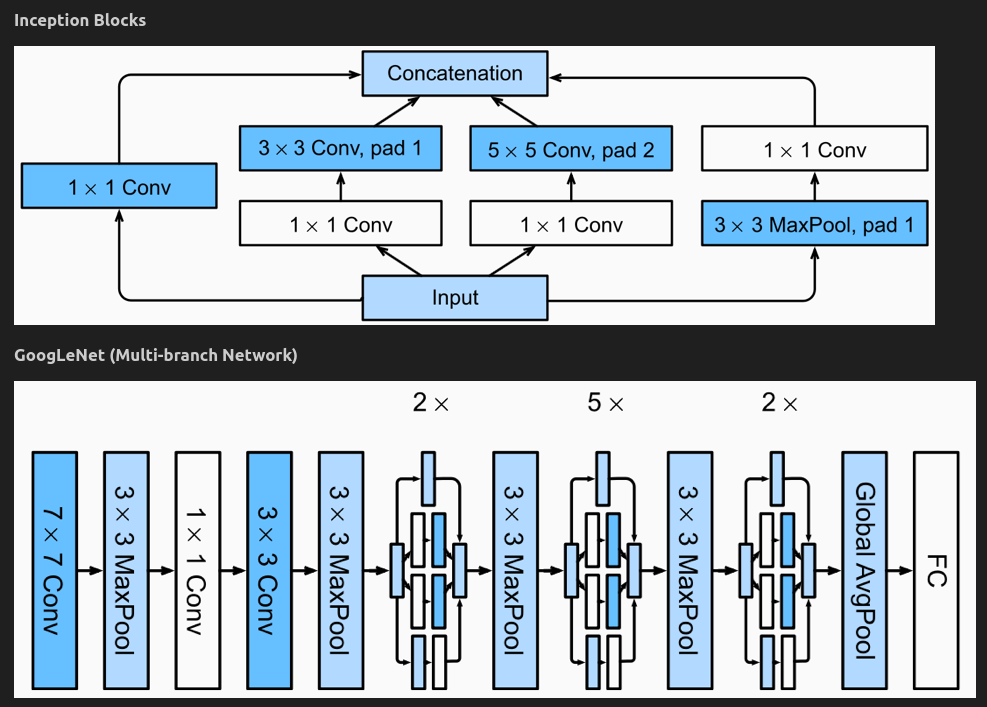**Inception Blocks**

## GoogLeNet

In [6]:
import torch
from torch import nn
import torch.nn.functional as F


class BasicConv2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: any
    )->None:

        super(BasicConv2D, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            bias=False,
            **kwargs
        )
        self.ReLU = nn.ReLU(True)
        self.batchnorm2d = nn.BatchNorm2d(
            out_channels,
            eps=0.001
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv(x)
        y = self.batchnorm2d(y)
        y = self.ReLU(y)
        return y


class Inception(nn.Module):
    def __init__(
        self,
        in_channels: int,
        # output channels
        ch1x1: int,             #
        ch3x3_reduced: int,     #
        ch3x3: int,
        ch5x5_reduced: int,
        ch5x5: int,
        pool_proj: int
    ) -> None:
        super(Inception, self).__init__()

        # First Branch : 1x1 Conv
        self.branch1 = BasicConv2D(
            in_channels=in_channels,
            out_channels=ch1x1,
            kernel_size=(1,1),
            padding=(0,0),
            stride=1
        )
        # Second Branch: 1x1 Conv and 3x3 Conv
        self.branch2 = nn.Sequential(
            BasicConv2D(
                in_channels=in_channels,
                out_channels=ch3x3_reduced,
                kernel_size=(1,1),
                padding=(0,0),
                stride=1
            ),
            BasicConv2D(
                in_channels=ch3x3_reduced,
                out_channels=ch3x3,
                kernel_size=(3,3),
                padding=(1,1),
                stride=1
            )
        )
        # Third Branch: 1x1 Conv and 5x5 Conv
        self.branch3 = nn.Sequential(
            BasicConv2D(
                in_channels=in_channels,
                out_channels=ch5x5_reduced,
                kernel_size=(1,1),
                padding=(0,0),
                stride=1
            ),
            BasicConv2D(
                in_channels=ch5x5_reduced,
                out_channels=ch5x5,
                padding=(2,2),
                stride=1,
                kernel_size=(5,5)
            )
        )
        # Fourth Branch: 3x3 MaxPool and 1x1 Conv
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(
                kernel_size=(3,3),
                padding=(1,1),
                stride=1,
                ceil_mode=True
            ),
            BasicConv2D(
                in_channels=in_channels,
                out_channels=pool_proj,
                kernel_size=(1,1),
                padding=(0,0),
                stride=1
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        output = [branch1, branch2, branch3, branch4]
        output = torch.cat(output, 1)   # concatenation
        return output

class InceptionAux(nn.Module):
    def __init__(
        self,
        in_channels: int,
        n_classes: int,
        dropout: float = 0.7
    ):
        super(InceptionAux, self).__init__()
        self.avgpool = nn.AvgPool2d(
            kernel_size=(5,5),
            stride=3,
            padding=(0,0)
        )
        self.conv = BasicConv2D(
            in_channels=in_channels,
            out_channels=128,
            kernel_size=(1,1),
            padding=(0,0),
            stride=1
        )
        self.ReLU = nn.ReLU(True)
        self.fc1 = nn.Linear(
            in_features=2048,
            out_features=1024
        )
        self.fc2 = nn.Linear(
            in_features=1024,
            out_features=n_classes
        )
        self.dropout = nn.Dropout2d(
            p=dropout,
            inplace=True
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.avgpool(x)
        out = self.conv(out)
        out = torch.flatten(out, 1)
        out = self.ReLU(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

class GoogLeNet(nn.Module):
    def __init__(
        self,
        aux_logits: bool = False,
        n_classes: int = 1000,
        dropout: float = 0.4,
        dropout_aux: float = 0.7
    ) -> None:
        super(GoogLeNet, self).__init__()
        self.aux_logit = aux_logits      # Tag Auxiliary Classifier (True/False)
        self.dropout_aux = dropout_aux

        self.conv1 = BasicConv2D(in_channels=3, out_channels=64, kernel_size=(7,7), stride=2, padding=(3,3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=(0,0))
        self.conv2 = BasicConv2D(in_channels=64, out_channels=64, kernel_size=(1,1), stride=1, padding=(0,0))
        self.conv3 = BasicConv2D(in_channels=64, out_channels=192, kernel_size=(3,3), stride=1, padding=(0,0))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=(0,0), ceil_mode=True)

        self.inception3a = Inception(in_channels=192, ch1x1=64, ch3x3_reduced=96, ch3x3=128, ch5x5_reduced=16, ch5x5=32, pool_proj=32) # Output: 28x28x256
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64) # Output : 28x28x480
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=(0,0), ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(3,3), padding=(0,0), stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = InceptionAux(512, n_classes, dropout_aux)
            self.aux2 = InceptionAux(528, n_classes, dropout_aux)
        else:
            self.aux1 = None
            self.aux2 = None

        # self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=1, padding=(0,0))
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(in_features=1024, out_features=n_classes)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.maxpool2(out)

        out = self.inception3a(out)
        out = self.inception3b(out)
        out = self.maxpool3(out)

        out = self.inception4a(out)
        aux1 = None
        if self.aux1 is not None:
            if self.training:
                aux1 = self.aux1(out)

        out = self.inception4b(out)
        out = self.inception4c(out)
        out = self.inception4d(out)
        aux2 = None
        if self.aux2 is not None:
            if self.training:
                aux2 = self.aux2(out)
        out = self.inception4e(out)
        out = self.maxpool4(out)

        out = self.inception5a(out)
        out = self.inception5b(out)
        out = self.avgpool(out)
        out = self.dropout(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

## Train and Evaluate

In [8]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/content/vinafood21/VinaFood21/train', transform=transform)
test_dataset  = datasets.ImageFolder('/content/vinafood21/VinaFood21/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_dataset.classes)


def train (dataloader: DataLoader) -> list:
    pass
model = GoogLeNet(n_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def train_model(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# =========================
# 5. Hàm evaluate
# =========================
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return acc, prec, rec, f1

# =========================
# 6. Vòng lặp train & evaluate
# =========================
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader)
    acc, prec, rec, f1 = evaluate_model(model, test_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-score: {f1:.4f}")
    print("-" * 50)

cuda


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10]
Train Loss: 2.6281
Accuracy: 0.2291 | Precision: 0.1991 | Recall: 0.1975 | F1-score: 0.1571
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/10]
Train Loss: 2.3386
Accuracy: 0.2872 | Precision: 0.2772 | Recall: 0.2451 | F1-score: 0.2300
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/10]
Train Loss: 2.1348
Accuracy: 0.3025 | Precision: 0.3188 | Recall: 0.2470 | F1-score: 0.2301
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/10]
Train Loss: 1.9473
Accuracy: 0.3768 | Precision: 0.3807 | Recall: 0.3393 | F1-score: 0.3264
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/10]
Train Loss: 1.8377
Accuracy: 0.3647 | Precision: 0.3740 | Recall: 0.3367 | F1-score: 0.3007
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/10]
Train Loss: 1.7091
Accuracy: 0.3961 | Precision: 0.4172 | Recall: 0.3714 | F1-score: 0.3605
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/10]
Train Loss: 1.5992
Accuracy: 0.4333 | Precision: 0.4536 | Recall: 0.4040 | F1-score: 0.4046
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/10]
Train Loss: 1.4815
Accuracy: 0.4445 | Precision: 0.4685 | Recall: 0.4177 | F1-score: 0.4011
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/10]
Train Loss: 1.3683
Accuracy: 0.4553 | Precision: 0.4829 | Recall: 0.4494 | F1-score: 0.4349
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/10]
Train Loss: 1.2576
Accuracy: 0.4758 | Precision: 0.4952 | Recall: 0.4658 | F1-score: 0.4508
--------------------------------------------------
